In [68]:
from preprocess import Preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from evaluation import plot_confusion_matrix, plot_feature_importance, plot_parameter_sensitivity, get_results, get_cross_validation_scores
from scipy.stats import randint, loguniform
import pandas as pd
import matplotlib.pylab as plt
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
import numpy as np
from scipy.stats import randint, uniform
from tensorflow.keras.optimizers import Adam
import time

In [69]:
# df to save random search times
index_name = 'model_name'
column_name = 'randsearch_time'

df_times = pd.DataFrame(
    index = pd.Index([], name=index_name),
    columns = [column_name],
    dtype = np.float64
)

## Base model with using SMOTE

In [70]:
# Create train and test split
pp = Preprocessing()
df = pp.load_data()
X_train, X_test, y_train, y_test = pp.preprocess_data(df)

# Use SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)


# Get feature and target names
temp_df = df.drop(['ID', 'class'], axis=1)
feature_names = temp_df.columns.tolist()
target_names = ['False (0)', 'True (1)']

In [71]:
early_stopper = EarlyStopping(
    monitor='val_loss', 
    patience=10,        
    restore_best_weights=True
)

# required for crossval
def build_model(input_dim):
    model = Sequential([
        Input(shape = (input_dim,)),
        Dense(100, activation='relu'),
        Dense(2, activation='softmax') # Using  sparse_categorical_crossentropy as the labels aren't one-hot encoded
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model

# Required for crossval
keras_clf = KerasClassifier(
    model=build_model,
    model__input_dim=X_train.shape[1], 
    epochs=500,
    batch_size=32,
    callbacks=[early_stopper],
    validation_split=0.16,
    verbose=0 
)

base_model = build_model(X_train.shape[1])
history = base_model.fit(
    X_train, 
    y_train, 
    epochs=500,
    batch_size=32,
    validation_split=0.15,
    callbacks=[early_stopper],
    verbose=0 
)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
              precision    recall  f1-score   support

   False (0)       0.97      0.94      0.96        35
    True (1)       0.91      0.95      0.93        22

    accuracy                           0.95        57
   macro avg       0.94      0.95      0.94        57
weighted avg       0.95      0.95      0.95        57



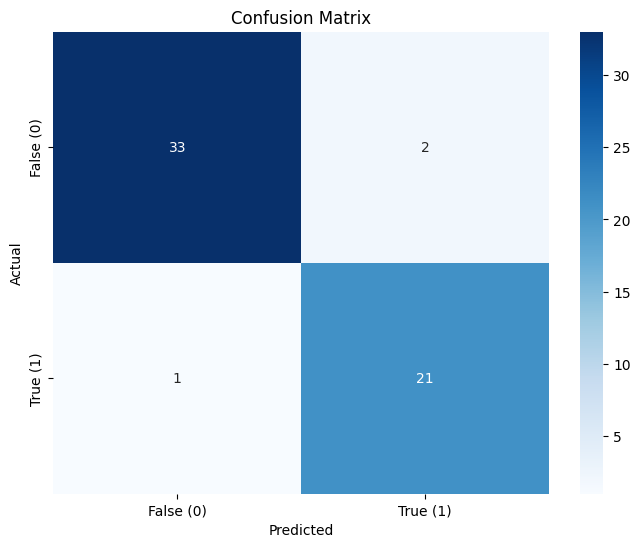

In [72]:
y_pred = base_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
get_results(y_test, y_pred, target_names)

In [73]:
get_cross_validation_scores(keras_clf, X_train, y_train)

10-Fold CV Scores: [0.80041797 0.93103448 0.82525944 0.83176594 0.57802198 0.82260493
 0.78351648 0.7952381  0.98181818 1.        ]
Average f1_weighted Score: 0.8350
Standard Deviation: 0.1139


In [74]:
model_name = 'mlp_smote'

param_distributions = {
    'model__hidden_units': randint(50, 200), 
    'model__activation': ['relu', 'tanh'],   
    'optimizer__learning_rate': uniform(loc=0.0001, scale=0.01), 
    
    'batch_size': [16, 32, 64],  
    'epochs': [50, 100],       
}

def build_model_tune(input_dim, hidden_units=100, activation='relu', learning_rate=0.001):
    
    optimizer = Adam(learning_rate=learning_rate) 
    
    model = Sequential([
        Input(shape = (input_dim,)),
        Dense(hidden_units, activation=activation),
        Dense(2, activation='softmax') 
    ])

    model.compile(
        optimizer=optimizer, 
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model

keras_clf = KerasClassifier(
    model=build_model_tune,
    model__input_dim=X_train.shape[1],
    callbacks=[early_stopper], 
    verbose=0,
    validation_split = 0.1
)


random_search_keras = RandomizedSearchCV(
    estimator=keras_clf,
    param_distributions=param_distributions,
    n_iter=50,       
    scoring='f1_weighted',
    cv=10,          
    random_state=42,
    n_jobs=-1        
)

start_time = time.time()
random_search_keras.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

df_times.loc[model_name, column_name] = training_time

print(f"Best F1 Weighted Score: {random_search_keras.best_score_:.4f}")
print(f"Best Hyperparameters: {random_search_keras.best_params_}")

Best F1 Weighted Score: 0.9071
Best Hyperparameters: {'batch_size': 16, 'epochs': 100, 'model__activation': 'tanh', 'model__hidden_units': 192, 'optimizer__learning_rate': np.float64(0.007655511385430487)}


              precision    recall  f1-score   support

   False (0)       1.00      0.83      0.91        35
    True (1)       0.79      1.00      0.88        22

    accuracy                           0.89        57
   macro avg       0.89      0.91      0.89        57
weighted avg       0.92      0.89      0.90        57



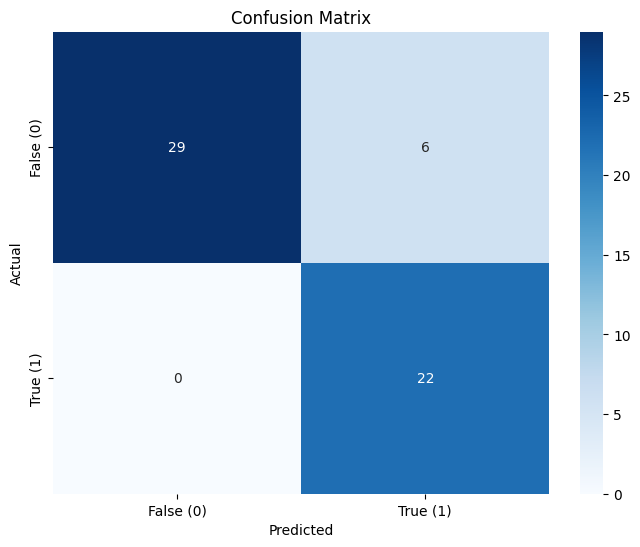

In [75]:
best_clf = random_search_keras.best_estimator_
y_proba_optimized = best_clf.predict_proba(X_test)
y_pred_optimized = np.argmax(y_proba_optimized, axis=1)

get_results(y_test, y_pred_optimized, target_names)


## Base model without SMOTE

In [76]:
# Create train and test split
pp = Preprocessing()
df = pp.load_data()
X_train, X_test, y_train, y_test = pp.preprocess_data(df)

# Get feature and target names
temp_df = df.drop(['ID', 'class'], axis=1)
feature_names = temp_df.columns.tolist()
target_names = ['False (0)', 'True (1)']

In [77]:
early_stopper = EarlyStopping(
    monitor='val_loss', 
    patience=10,        
    restore_best_weights=True
)

# required for crossval
def build_model(input_dim):
    model = Sequential([
        Input(shape = (input_dim,)),
        Dense(100, activation='relu'),
        Dense(2, activation='softmax') # Using  sparse_categorical_crossentropy as the labels aren't one-hot encoded
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model

# Required for crossval
keras_clf = KerasClassifier(
    model=build_model,
    model__input_dim=X_train.shape[1], 
    epochs=500,
    batch_size=32,
    callbacks=[early_stopper],
    validation_split=0.16,
    verbose=0 
)

base_model = build_model(X_train.shape[1])
history = base_model.fit(
    X_train, 
    y_train, 
    epochs=500,
    batch_size=32,
    validation_split=0.15,
    callbacks=[early_stopper],
    verbose=0 
)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
              precision    recall  f1-score   support

   False (0)       0.97      0.94      0.96        35
    True (1)       0.91      0.95      0.93        22

    accuracy                           0.95        57
   macro avg       0.94      0.95      0.94        57
weighted avg       0.95      0.95      0.95        57



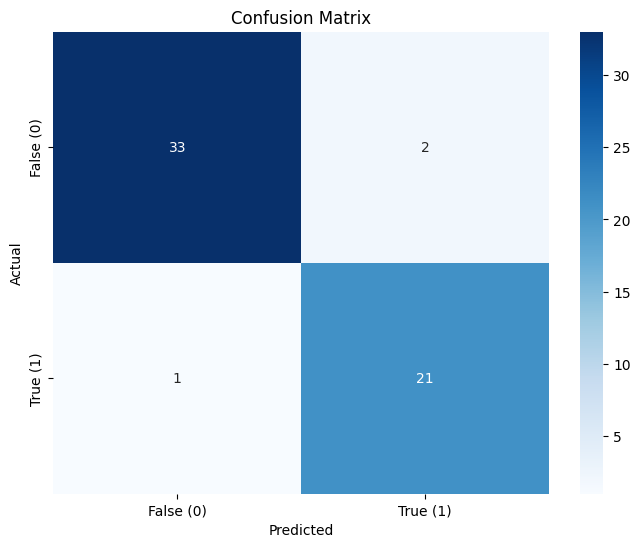

In [78]:
y_pred = base_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
get_results(y_test, y_pred, target_names)

In [79]:
get_cross_validation_scores(keras_clf, X_train, y_train)

10-Fold CV Scores: [0.46837945 0.87115266 0.70277142 0.7775413  0.83298827 0.49892716
 0.65085639 0.54796411 0.7741389  0.58328628]
Average f1_weighted Score: 0.6708
Standard Deviation: 0.1354


In [80]:
model_name = 'mlp_nosmote'

param_distributions = {
    'model__hidden_units': randint(50, 200), 
    'model__activation': ['relu', 'tanh'],   
    'optimizer__learning_rate': uniform(loc=0.0001, scale=0.01), 
    
    'batch_size': [16, 32, 64],  
    'epochs': [50, 100],       
}

def build_model_tune(input_dim, hidden_units=100, activation='relu', learning_rate=0.001):
    
    optimizer = Adam(learning_rate=learning_rate) 
    
    model = Sequential([
        Input(shape = (input_dim,)),
        Dense(hidden_units, activation=activation),
        Dense(2, activation='softmax') 
    ])

    model.compile(
        optimizer=optimizer, 
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model

keras_clf = KerasClassifier(
    model=build_model_tune,
    model__input_dim=X_train.shape[1],
    callbacks=[early_stopper], 
    verbose=0,
    validation_split = 0.1
)


random_search_keras = RandomizedSearchCV(
    estimator=keras_clf,
    param_distributions=param_distributions,
    n_iter=100,       
    scoring='f1_weighted',
    cv=10,          
    random_state=42,
    n_jobs=-1        
)

start_time = time.time()
random_search_keras.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

df_times.loc[model_name, column_name] = training_time
print(f"Best F1 Weighted Score: {random_search_keras.best_score_:.4f}")
print(f"Best Hyperparameters: {random_search_keras.best_params_}")

/Users/domapetho/Documents/semester_1/ML/machinelearning-tuw/EX1/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best F1 Weighted Score: 0.8869
Best Hyperparameters: {'batch_size': 16, 'epochs': 100, 'model__activation': 'tanh', 'model__hidden_units': 192, 'optimizer__learning_rate': np.float64(0.007655511385430487)}


              precision    recall  f1-score   support

   False (0)       1.00      0.80      0.89        35
    True (1)       0.76      1.00      0.86        22

    accuracy                           0.88        57
   macro avg       0.88      0.90      0.88        57
weighted avg       0.91      0.88      0.88        57



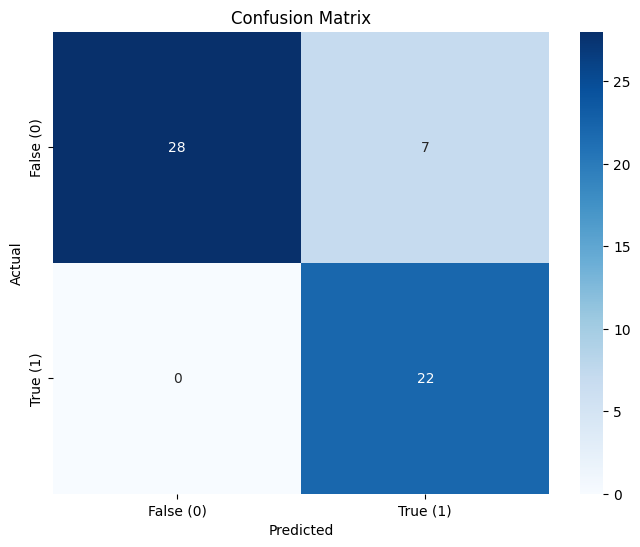

In [81]:
best_clf = random_search_keras.best_estimator_
y_proba_optimized = best_clf.predict_proba(X_test)
y_pred_optimized = np.argmax(y_proba_optimized, axis=1)

get_results(y_test, y_pred_optimized, target_names)


## Unscaled data

In [82]:
# Create train and test split
pp = Preprocessing()
df = pp.load_data()
X_train, X_test, y_train, y_test = pp.preprocess_data(df, scale=False)

# Use SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
print(f"SMOTE class distribution: {Counter(y_train)}")

# Get feature and target names
temp_df = df.drop(['ID', 'class'], axis=1)
feature_names = temp_df.columns.tolist()
target_names = ['False (0)', 'True (1)']

SMOTE class distribution: Counter({0: 142, 1: 142})


In [83]:
# Ensure 'early_stopper' is defined before using it
early_stopper = EarlyStopping(
    monitor='val_loss', 
    patience=10,        
    restore_best_weights=True
)

# required for crossval
def build_model(input_dim):
    model = Sequential([
        Input(shape = (input_dim,)),
        Dense(100, activation='relu'),
        Dense(2, activation='softmax') # Useing  sparse_categorical_crossentropy as the labels aren't one-hot encoded
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model


keras_clf = KerasClassifier(
    model=build_model,
    model__input_dim=X_train.shape[1], 
    epochs=500,
    batch_size=32,
    callbacks=[early_stopper],
    validation_split=0.1,
    verbose=0 
)

base_model = build_model(X_train.shape[1])
history = base_model.fit(
    X_train, 
    y_train, 
    epochs=500,
    batch_size=32,
    validation_split=0.15,
    callbacks=[early_stopper],
    verbose=0 
)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
              precision    recall  f1-score   support

   False (0)       0.88      0.63      0.73        35
    True (1)       0.59      0.86      0.70        22

    accuracy                           0.72        57
   macro avg       0.74      0.75      0.72        57
weighted avg       0.77      0.72      0.72        57



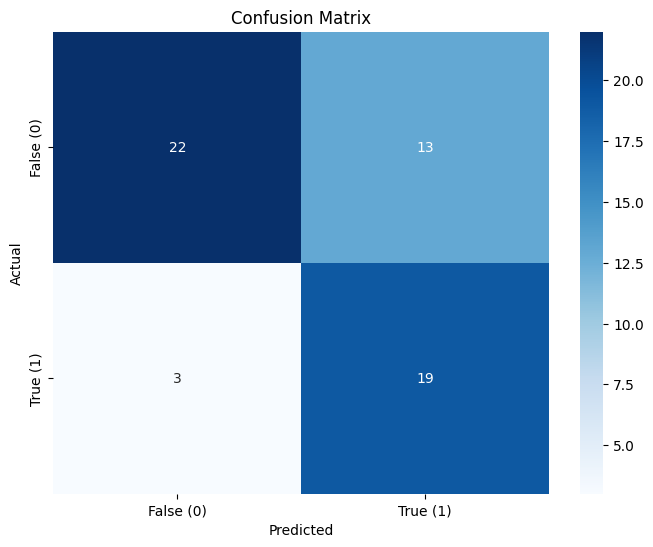

In [84]:
y_pred = base_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
get_results(y_test, y_pred, target_names)

In [85]:
get_cross_validation_scores(keras_clf, X_train, y_train)

10-Fold CV Scores: [0.63482544 0.79800363 0.70279146 0.17683466 0.18796992 0.4670151
 0.44444444 0.69339356 0.3030303  0.96296296]
Average f1_weighted Score: 0.5371
Standard Deviation: 0.2512


In [86]:
model_name = 'mlp_smote_unscaled'

param_distributions = {
    'model__hidden_units': randint(50, 200), 
    'model__activation': ['relu', 'tanh'],   
    'optimizer__learning_rate': uniform(loc=0.0001, scale=0.01), 
    
    'batch_size': [16, 32, 64],  
    'epochs': [50, 100],       
}

def build_model_tune(input_dim, hidden_units=100, activation='relu', learning_rate=0.001):
    
    optimizer = Adam(learning_rate=learning_rate) 
    
    model = Sequential([
        Dense(hidden_units, activation=activation, input_shape=(input_dim,)),
        Dense(2, activation='softmax') 
    ])

    model.compile(
        optimizer=optimizer, 
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model

keras_clf = KerasClassifier(
    model=build_model_tune,
    model__input_dim=X_train.shape[1],
    callbacks=[early_stopper], 
    validation_split = 0.15,
    verbose=0 
)


random_search_keras = RandomizedSearchCV(
    estimator=keras_clf,
    param_distributions=param_distributions,
    n_iter=100,       
    scoring='f1_weighted',
    cv=5,          
    random_state=42,
    n_jobs=-1        
)

start_time = time.time()
random_search_keras.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time


df_times.loc[model_name, column_name] = training_time
print(f"Best F1 Weighted Score: {random_search_keras.best_score_:.4f}")
print(f"Best Hyperparameters: {random_search_keras.best_params_}")

/Users/domapetho/Documents/semester_1/ML/machinelearning-tuw/EX1/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/domapetho/Documents/semester_1/ML/machinelearning-tuw/EX1/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/domapetho/Documents/semester_1/ML/machinelearning-tuw/EX1/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When usi

Best F1 Weighted Score: 0.7987
Best Hyperparameters: {'batch_size': 16, 'epochs': 50, 'model__activation': 'tanh', 'model__hidden_units': 177, 'optimizer__learning_rate': np.float64(0.005277513505274801)}


              precision    recall  f1-score   support

   False (0)       0.83      0.71      0.77        35
    True (1)       0.63      0.77      0.69        22

    accuracy                           0.74        57
   macro avg       0.73      0.74      0.73        57
weighted avg       0.75      0.74      0.74        57



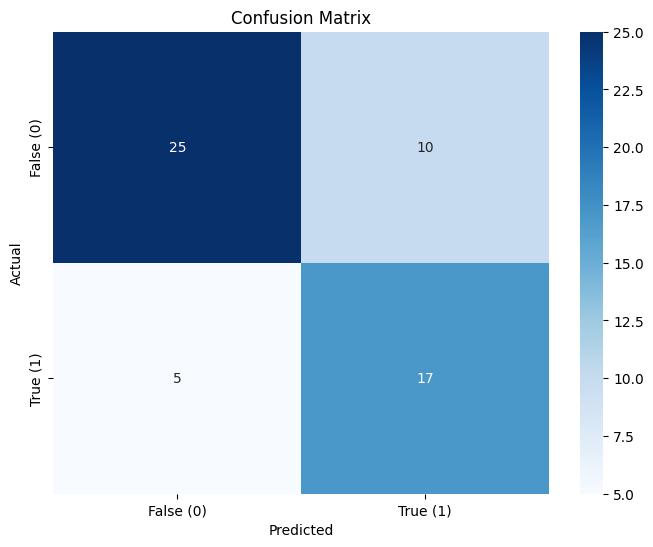

In [87]:
best_clf = random_search_keras.best_estimator_
y_proba_optimized = best_clf.predict_proba(X_test)
y_pred_optimized = np.argmax(y_proba_optimized, axis=1)

get_results(y_test, y_pred_optimized, target_names)


In [88]:
df_times.to_csv('randsearch_times_mlp.csv')